
# Autoencoder skip-connection
---
# 1 Initialization

In [1]:
import os
from os import listdir
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

import tensorflow as tf
from tensorflow.keras import backend
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, UpSampling2D, Input, Activation, BatchNormalization, Conv2DTranspose, concatenate, RepeatVector, Reshape
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Dataset

In [3]:
num_imgs = len(listdir('/kaggle/input/landscape-pictures'))
print("immagini nel dataset: ", num_imgs)

immagini nel dataset:  4319


In [ ]:
# Images normalization
train_datagen = ImageDataGenerator(rescale=1. / 255)
num_imgs = 4300
# resize and loading of the dataset
train = train_datagen.flow_from_directory('/kaggle/input/', 
                                          target_size=(128, 128), 
                                          batch_size=num_imgs,
                                          classes = ['landscape-pictures'], # it takes it from the subdirectory, considering it as a class
                                          class_mode=None)


Found 4319 images belonging to 1 classes.


## 2 Data preprocessing

### LAB conversion

![](https://reference.wolfram.com/language/ref/Files/LABColor.en/Image_1.gif)

Let's convert the RGB images to the LAB color space, so that the model will have to predict only two channels instead of three.
* In Y, we set the channels (a*, b*), where a* represents the red/green values and b* the blue/yellow values.
* In X, we set the channel (l*), i.e., the luminance.


In [ ]:
X =[]
Y =[]

# Ciclo attraverso le immagini nell'oggetto 'train[0]', ossia il primo batch prodotto dal metodo 'flow_from_directory'
for img in train[0]:
  try:
      lab = rgb2lab(img) # picture conversion from RGB to LAB
      X.append(lab[:,:,0]) # X stands for lightness
      Y.append(lab[:,:,1:] / 128) 
        # A and B values shift from -127 e 128 so we divide of 128
        # to limit value from -1 to 1.
  except:
     print('error') # error handler
        
X = np.array(X)
Y = np.array(Y)

# reshape the X to match Y
X = X.reshape(X.shape+(1,))

print(X.shape)
print(Y.shape)


(4300, 128, 128, 1)
(4300, 128, 128, 2)


## 3 Model definition

![](https://miro.medium.com/v2/resize:fit:1400/1*x0kR2rGlTibVbu8InCNBVg.jpeg)

U-net architecture

---
The proposed model is an autoencoder inspired by the **U-net** architecture. Through TensorFlow's built-in function *Concatenate()*, **skip connections** are implemented between the encoder and decoder to ensure that information is retained even during reconstruction. After each convolution, **batch normalization** is also applied.


* The **encoder** takes as input a 256x256 image and extracts features through a series of convolutional layers. A kernel size of 4 is used to increase the model's receptive field.
* In the **bottleneck**, we added a convolutional layer that leverages the concept of **dilation**, as it has been shown to be useful for increasing the network's perceptive capacity without increasing the image size or the number of parameters.
* The **decoder** increases the dimensions of the image using *Conv2DTranspose*.

**input**: 
* Images [256, 256, 1] in lab format with L* as the only channel

**output**:
* Prediction of the color channels a*, b* [256, 256, 2]

---

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Conv2DTranspose, Concatenate

input_shape = (128, 128, 1)

# Define input layer
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(32, kernel_size=4, strides=2, padding='same', activation='relu')(inputs)
conv1_bn = BatchNormalization()(conv1)
conv2 = Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu')(conv1_bn)
conv2_bn = BatchNormalization()(conv2)
conv3 = Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu')(conv2_bn)
conv3_bn = BatchNormalization()(conv3)
conv4 = Conv2D(256, kernel_size=4, strides=2, padding='same', activation='relu')(conv3_bn)
conv4_bn = BatchNormalization()(conv4)

# Dilation
conv5 = Conv2D(256, kernel_size=4, strides=1, padding='same', dilation_rate=2, activation='relu')(conv4_bn)
conv5_bn = BatchNormalization()(conv5)

# Decoder e concatenazione
t_conv1 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(conv5_bn)
t_conv1_bn = BatchNormalization()(t_conv1)
concat1 = Concatenate()([t_conv1_bn, conv3_bn])
t_conv2 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(concat1)
t_conv2_bn = BatchNormalization()(t_conv2)
concat2 = Concatenate()([t_conv2_bn, conv2_bn])
t_conv3 = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(concat2)
t_conv3_bn = BatchNormalization()(t_conv3)
concat3 = Concatenate()([t_conv3_bn, conv1_bn])
t_conv4 = Conv2DTranspose(2, kernel_size=4, strides=2, padding='same', activation='relu')(concat3)

# Output 
output = Conv2D(2, kernel_size=3, strides=1, padding='same')(t_conv4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   544         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

We compile the model using Adam as the **optimizer** and MSE as the **loss**. The latter will measure the difference between the a, b channels produced by the model and those provided as the actual values in the Y tensor.


In [ ]:
# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])

# Print the summary of the model
model.summary()

In [8]:
history = model.fit(X,Y,validation_split=0.15, epochs=200, batch_size=32)

Epoch 1/200
115/115 [==============================] - 17s 36ms/step - loss: 0.0302 - accuracy: 0.5745 - val_loss: 0.0170 - val_accuracy: 0.5428
Epoch 2/200
115/115 [==============================] - 3s 29ms/step - loss: 0.0161 - accuracy: 0.6163 - val_loss: 0.0163 - val_accuracy: 0.5995
Epoch 3/200
115/115 [==============================] - 3s 28ms/step - loss: 0.0154 - accuracy: 0.6349 - val_loss: 0.0151 - val_accuracy: 0.6198
Epoch 4/200
115/115 [==============================] - 3s 29ms/step - loss: 0.0149 - accuracy: 0.6476 - val_loss: 0.0171 - val_accuracy: 0.6054
Epoch 5/200
115/115 [==============================] - 3s 28ms/step - loss: 0.0144 - accuracy: 0.6617 - val_loss: 0.0167 - val_accuracy: 0.6123
Epoch 6/200
115/115 [==============================] - 3s 27ms/step - loss: 0.0143 - accuracy: 0.6629 - val_loss: 0.0144 - val_accuracy: 0.6422
Epoch 7/200
115/115 [==============================] - 3s 29ms/step - loss: 0.0140 - accuracy: 0.6715 - val_loss: 0.0141 - val_accuracy

In [9]:
def plot_accuracy_loss(history):
    # Retrieve the accuracy and loss values from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a figure with subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Plot accuracy
    ax1.plot(accuracy, label='Training Accuracy')
    ax1.plot(val_accuracy, label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Show the plot
    plt.show()

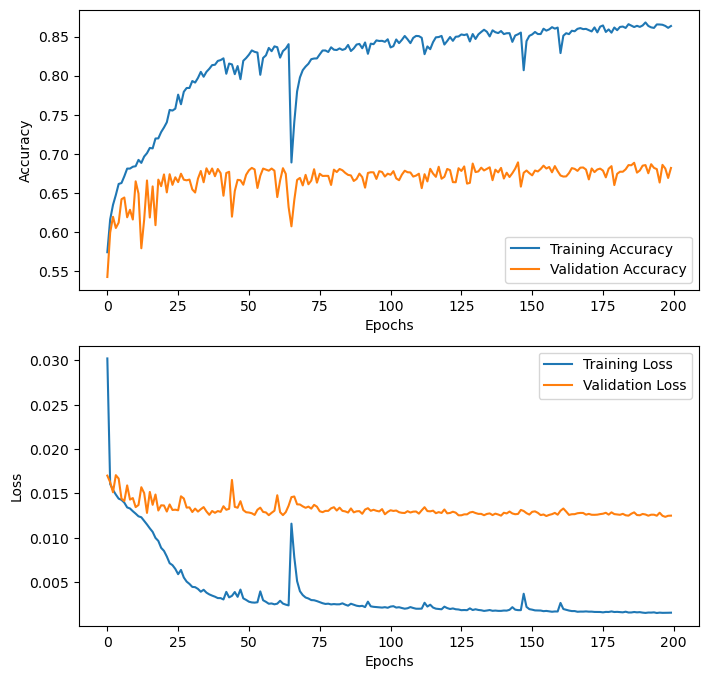

In [10]:
plot_accuracy_loss(history)

## 3.1 Save model (on kaggle only)

In [15]:
model.save('/kaggle/working/residual_200epochs_128pix.h5')

## 4 Risultati

In [ ]:
# It takes all the images from a directory e and it return an images array
def load_images_from_directory(directory, num_photos):
    len_dir = len(os.listdir(directory))
    assert(num_photos <= len_dir), f"la directory contiene {len_dir} immagini, ma ne vuoi mostrare {num_photos}."
    images = []
    count = 0
    
    for filename in os.listdir(directory):
        if count >= num_photos:
            break
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = img_to_array(load_img(filepath))
            images.append(image)
            count += 1

    return images


def test_model(images, model):
    test_images = []         # List to store the original test images
    luminance_images = []    # List to store the luminance images
    predicted_images = []    # List to store the predicted images

    for image in images:
        # Resize of the image to use it as input for the model
        image = resize(image, (128, 128), anti_aliasing=True)
        test = resize(image, (128, 128), anti_aliasing=True)

        # normalization
        test *= 1.0 / 255

        # conversion from rgb to lab
        lab_test = rgb2lab(test)

        # Extract the L channel both from the image both from the embeddings
        luminance_test = lab_test[:, :, 0]

        # Reshape 
        luminance_test_4d = luminance_test.reshape((1, 128, 128, 1))

        # prediction
        ab_test = model.predict(luminance_test_4d)
        ab_test = ab_test * 128

        # we merge all the channel(L,A and B)
        cur = np.zeros((128, 128, 3))
        cur[:, :, 0] = luminance_test
        cur[:, :, 1:] = ab_test
        # rgb conversion
        cur = lab2rgb(cur)

        # Append 
        test_images.append(image/255) # rquired for the plot on matplotlib
        luminance_images.append(luminance_test)
        predicted_images.append(cur)

    # Return the test images, luminance images, and predicted images
    return test_images, luminance_images, predicted_images

1/1 [==============================] - 0s 26ms/step


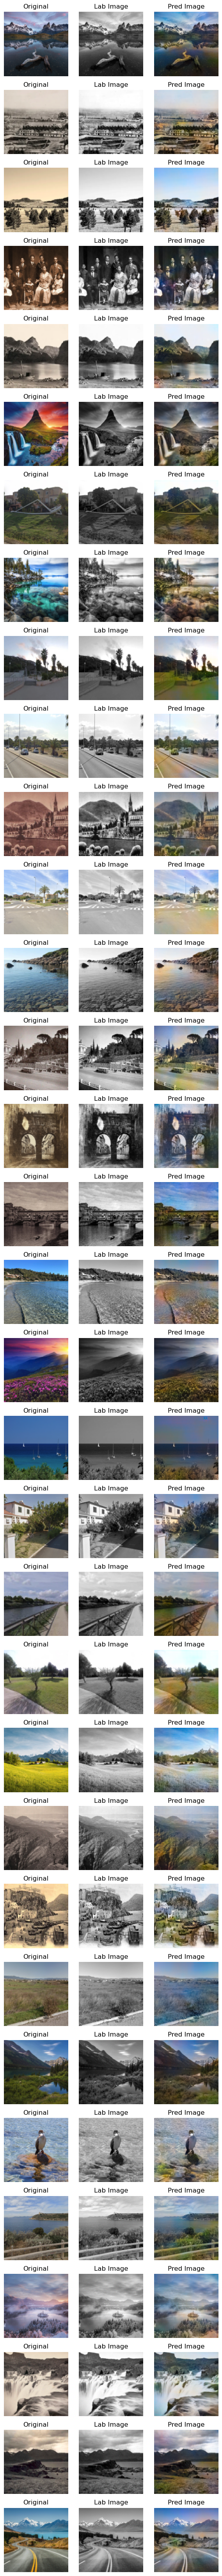

In [12]:
import os
num_imgs = 33
path = '/kaggle/input/complete-test/landscape-test/landscape-test'
test_imgs = load_images_from_directory(path, num_imgs)

test_images, luminance_images, predicted_images = test_model(test_imgs, model)

import numpy as np
import matplotlib.pyplot as plt

rows = 3
cols = num_imgs

fig, axes = plt.subplots(cols, rows, figsize=(rows * 2, cols * 2))

for i in range(num_imgs):
    # Plot original image
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title("Original")

    # Plot image with L channel
    axes[i, 1].imshow(luminance_images[i], cmap='gray')
    axes[i, 1].set_title("Lab Image")

    # Plot predicted image
    axes[i, 2].imshow(predicted_images[i])
    axes[i, 2].set_title("Pred Image")

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
